In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/converted.zip
!unzip -q dataset/test9classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class MobileNetV1(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()

        def pointwise(input, output, stride):
            return nn.Sequential(
                nn.Conv2d(input, output, 3, stride, 1, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True)
                )

        def depthwise(input, output, stride):
            return nn.Sequential(
                
                nn.Conv2d(input, input, 3, stride, 1, groups=input, bias=False),
                nn.BatchNorm2d(input),
                nn.ReLU(inplace=True),

                
                nn.Conv2d(input, output, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            pointwise(input_channel, 32, 2),
            depthwise(32, 64, 1),
            depthwise(64, 128, 2),
            depthwise(128, 128, 1),
            depthwise(128, 256, 2),
            depthwise(256, 256, 1),
            depthwise(256, 512, 2),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 1024, 2),
            depthwise(1024, 1024, 1),
            nn.AvgPool2d(7)
        )
        self.fc = nn.Linear(1024, n_classes)

        self.model.apply(self.initialw)
        self.fc.apply(self.initialw)

    def initialw(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
with open('test9classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']
4050
4050


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 5 #
batch_size_val = 5

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('converted/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test9classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: DEB


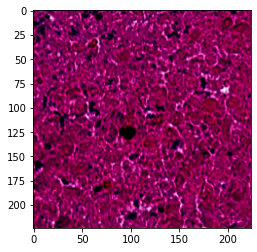

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = MobileNetV1(input_channel=3, n_classes=9).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("MobileNetSGD.pth"):
        os.remove("MobileNetSGD.pth")
      torch.save(model.state_dict(), 'MobileNetSGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = MobileNetV1(input_channel=3, n_classes=9).to(device)
  model.load_state_dict(torch.load('MobileNetSGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-7-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.7196

Test: Average loss: 1.8706, Accuracy: 2884/5400 (53.41%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1387

Test: Average loss: 0.9949, Accuracy: 3516/5400 (65.11%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9255

Test: Average loss: 1.0614, Accuracy: 3759/5400 (69.61%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7556

Test: Average loss: 0.6511, Accuracy: 4324/5400 (80.07%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6672

Test: Average loss: 0.6431, Accuracy: 4474/5400 (82.85%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5801

Test: Average loss: 0.5271, Accuracy: 4610/5400 (85.37%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5190

Test: Average loss: 0.3592, Accuracy: 4821/5400 (89.28%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4588

Test: Average loss: 0.3135, Accuracy: 4883/5400 (90.43%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4179

Test: Average loss: 0.3607, Accuracy: 4772/5400 (88.37%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3881

Test: Average loss: 0.2681, Accuracy: 4958/5400 (91.81%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3559

Test: Average loss: 0.2858, Accuracy: 4900/5400 (90.74%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3217

Test: Average loss: 0.2258, Accuracy: 5015/5400 (92.87%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3104

Test: Average loss: 0.2145, Accuracy: 5031/5400 (93.17%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2883

Test: Average loss: 0.3185, Accuracy: 4940/5400 (91.48%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2707

Test: Average loss: 0.2090, Accuracy: 5065/5400 (93.80%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2569

Test: Average loss: 0.2773, Accuracy: 4998/5400 (92.56%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2329

Test: Average loss: 0.2268, Accuracy: 4995/5400 (92.50%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2282

Test: Average loss: 0.2108, Accuracy: 5061/5400 (93.72%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2142

Test: Average loss: 0.2338, Accuracy: 5013/5400 (92.83%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1967

Test: Average loss: 0.1657, Accuracy: 5152/5400 (95.41%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1930

Test: Average loss: 0.1565, Accuracy: 5125/5400 (94.91%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1739

Test: Average loss: 0.1758, Accuracy: 5107/5400 (94.57%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1670

Test: Average loss: 0.1566, Accuracy: 5123/5400 (94.87%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1692

Test: Average loss: 0.1404, Accuracy: 5184/5400 (96.00%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1489

Test: Average loss: 0.1840, Accuracy: 5105/5400 (94.54%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1438

Test: Average loss: 0.3227, Accuracy: 4949/5400 (91.65%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1338

Test: Average loss: 0.1872, Accuracy: 5101/5400 (94.46%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1337

Test: Average loss: 0.1868, Accuracy: 5120/5400 (94.81%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1251

Test: Average loss: 0.1525, Accuracy: 5152/5400 (95.41%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1178

Test: Average loss: 0.1501, Accuracy: 5176/5400 (95.85%)

Test: Average loss: 0.1550, Accuracy: 3882/4050 (95.85%)

Experiment:  2
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.6258

Test: Average loss: 1.8414, Accuracy: 2556/5400 (47.33%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1256

Test: Average loss: 1.3526, Accuracy: 3081/5400 (57.06%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8997

Test: Average loss: 0.9132, Accuracy: 4006/5400 (74.19%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7652

Test: Average loss: 1.7890, Accuracy: 3786/5400 (70.11%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6553

Test: Average loss: 0.5990, Accuracy: 4432/5400 (82.07%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5463

Test: Average loss: 0.5009, Accuracy: 4571/5400 (84.65%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5050

Test: Average loss: 0.5783, Accuracy: 4731/5400 (87.61%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4443

Test: Average loss: 0.4987, Accuracy: 4772/5400 (88.37%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4137

Test: Average loss: 0.2944, Accuracy: 4849/5400 (89.80%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3681

Test: Average loss: 0.4903, Accuracy: 4829/5400 (89.43%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3404

Test: Average loss: 0.2256, Accuracy: 5023/5400 (93.02%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3311

Test: Average loss: 0.2989, Accuracy: 4879/5400 (90.35%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3123

Test: Average loss: 0.2748, Accuracy: 4892/5400 (90.59%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2808

Test: Average loss: 0.2005, Accuracy: 5043/5400 (93.39%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2513

Test: Average loss: 0.2831, Accuracy: 4902/5400 (90.78%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2432

Test: Average loss: 0.2398, Accuracy: 4983/5400 (92.28%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2158

Test: Average loss: 0.2503, Accuracy: 4963/5400 (91.91%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2073

Test: Average loss: 0.2141, Accuracy: 5041/5400 (93.35%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2006

Test: Average loss: 0.1635, Accuracy: 5125/5400 (94.91%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1850

Test: Average loss: 0.2104, Accuracy: 5037/5400 (93.28%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1878

Test: Average loss: 0.1818, Accuracy: 5123/5400 (94.87%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1645

Test: Average loss: 0.2008, Accuracy: 5097/5400 (94.39%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1617

Test: Average loss: 0.2057, Accuracy: 5036/5400 (93.26%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1463

Test: Average loss: 0.1954, Accuracy: 5095/5400 (94.35%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1415

Test: Average loss: 0.1609, Accuracy: 5100/5400 (94.44%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1352

Test: Average loss: 0.3570, Accuracy: 5073/5400 (93.94%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1226

Test: Average loss: 0.1692, Accuracy: 5106/5400 (94.56%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1147

Test: Average loss: 0.1298, Accuracy: 5184/5400 (96.00%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1146

Test: Average loss: 0.1179, Accuracy: 5198/5400 (96.26%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1153

Test: Average loss: 0.1452, Accuracy: 5141/5400 (95.20%)

Test: Average loss: 0.1177, Accuracy: 3907/4050 (96.47%)

Experiment:  3
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.6953

Test: Average loss: 1.7853, Accuracy: 2553/5400 (47.28%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1585

Test: Average loss: 1.9788, Accuracy: 3320/5400 (61.48%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9892

Test: Average loss: 1.4082, Accuracy: 3472/5400 (64.30%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8421

Test: Average loss: 1.3936, Accuracy: 3737/5400 (69.20%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7161

Test: Average loss: 0.5995, Accuracy: 4411/5400 (81.69%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6294

Test: Average loss: 0.6604, Accuracy: 4409/5400 (81.65%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5612

Test: Average loss: 1.1828, Accuracy: 4229/5400 (78.31%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4757

Test: Average loss: 0.4504, Accuracy: 4624/5400 (85.63%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4290

Test: Average loss: 0.3949, Accuracy: 4758/5400 (88.11%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3965

Test: Average loss: 0.3057, Accuracy: 4897/5400 (90.69%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3674

Test: Average loss: 0.3577, Accuracy: 4873/5400 (90.24%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3443

Test: Average loss: 0.4203, Accuracy: 4893/5400 (90.61%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3079

Test: Average loss: 0.2424, Accuracy: 5021/5400 (92.98%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2870

Test: Average loss: 0.3228, Accuracy: 4907/5400 (90.87%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2706

Test: Average loss: 0.3359, Accuracy: 4960/5400 (91.85%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2532

Test: Average loss: 0.1837, Accuracy: 5124/5400 (94.89%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2358

Test: Average loss: 0.1733, Accuracy: 5125/5400 (94.91%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2210

Test: Average loss: 0.1929, Accuracy: 5096/5400 (94.37%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2073

Test: Average loss: 0.2080, Accuracy: 5045/5400 (93.43%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1897

Test: Average loss: 0.2407, Accuracy: 5017/5400 (92.91%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1992

Test: Average loss: 0.1779, Accuracy: 5072/5400 (93.93%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1740

Test: Average loss: 0.1720, Accuracy: 5134/5400 (95.07%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1616

Test: Average loss: 0.2051, Accuracy: 5096/5400 (94.37%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1583

Test: Average loss: 0.1598, Accuracy: 5171/5400 (95.76%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1482

Test: Average loss: 0.1661, Accuracy: 5144/5400 (95.26%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1335

Test: Average loss: 0.1493, Accuracy: 5162/5400 (95.59%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1291

Test: Average loss: 0.3560, Accuracy: 5035/5400 (93.24%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1307

Test: Average loss: 0.1932, Accuracy: 5094/5400 (94.33%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1183

Test: Average loss: 0.1285, Accuracy: 5184/5400 (96.00%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1121

Test: Average loss: 0.1608, Accuracy: 5159/5400 (95.54%)

Test: Average loss: 0.1273, Accuracy: 3898/4050 (96.25%)

Experiment:  4
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.6307

Test: Average loss: 1.3988, Accuracy: 2611/5400 (48.35%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1451

Test: Average loss: 0.9791, Accuracy: 3547/5400 (65.69%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9568

Test: Average loss: 1.4378, Accuracy: 3535/5400 (65.46%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8370

Test: Average loss: 0.9271, Accuracy: 3671/5400 (67.98%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7491

Test: Average loss: 0.8578, Accuracy: 4269/5400 (79.06%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6344

Test: Average loss: 0.6293, Accuracy: 4473/5400 (82.83%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5770

Test: Average loss: 0.5578, Accuracy: 4468/5400 (82.74%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5060

Test: Average loss: 0.5078, Accuracy: 4551/5400 (84.28%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4602

Test: Average loss: 0.5897, Accuracy: 4675/5400 (86.57%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4020

Test: Average loss: 0.4333, Accuracy: 4781/5400 (88.54%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3703

Test: Average loss: 0.3962, Accuracy: 4775/5400 (88.43%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3496

Test: Average loss: 0.4052, Accuracy: 4759/5400 (88.13%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3321

Test: Average loss: 0.3120, Accuracy: 4883/5400 (90.43%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3058

Test: Average loss: 0.2748, Accuracy: 4973/5400 (92.09%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2905

Test: Average loss: 0.2244, Accuracy: 5030/5400 (93.15%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2658

Test: Average loss: 0.3194, Accuracy: 4966/5400 (91.96%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2379

Test: Average loss: 0.2815, Accuracy: 4992/5400 (92.44%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2362

Test: Average loss: 0.2196, Accuracy: 5115/5400 (94.72%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2166

Test: Average loss: 0.2100, Accuracy: 5042/5400 (93.37%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2050

Test: Average loss: 0.2465, Accuracy: 5034/5400 (93.22%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2008

Test: Average loss: 0.2280, Accuracy: 5088/5400 (94.22%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1838

Test: Average loss: 0.5513, Accuracy: 4911/5400 (90.94%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1725

Test: Average loss: 0.1313, Accuracy: 5173/5400 (95.80%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1605

Test: Average loss: 0.2601, Accuracy: 5037/5400 (93.28%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1522

Test: Average loss: 0.1783, Accuracy: 5110/5400 (94.63%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1460

Test: Average loss: 0.3125, Accuracy: 5048/5400 (93.48%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1411

Test: Average loss: 0.1901, Accuracy: 5105/5400 (94.54%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1312

Test: Average loss: 0.1596, Accuracy: 5161/5400 (95.57%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1317

Test: Average loss: 0.1229, Accuracy: 5177/5400 (95.87%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1093

Test: Average loss: 0.1381, Accuracy: 5182/5400 (95.96%)

Test: Average loss: 0.1461, Accuracy: 3894/4050 (96.15%)

Experiment:  5
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.6225

Test: Average loss: 1.7701, Accuracy: 2712/5400 (50.22%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1603

Test: Average loss: 1.3256, Accuracy: 3336/5400 (61.78%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9760

Test: Average loss: 2.3793, Accuracy: 3188/5400 (59.04%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8278

Test: Average loss: 0.7768, Accuracy: 4124/5400 (76.37%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7274

Test: Average loss: 1.3370, Accuracy: 3935/5400 (72.87%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6178

Test: Average loss: 0.5577, Accuracy: 4548/5400 (84.22%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5692

Test: Average loss: 0.8994, Accuracy: 4344/5400 (80.44%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4953

Test: Average loss: 0.5379, Accuracy: 4687/5400 (86.80%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4553

Test: Average loss: 0.4262, Accuracy: 4716/5400 (87.33%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4099

Test: Average loss: 0.3887, Accuracy: 4765/5400 (88.24%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3817

Test: Average loss: 0.2727, Accuracy: 4975/5400 (92.13%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3385

Test: Average loss: 0.3835, Accuracy: 4918/5400 (91.07%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3108

Test: Average loss: 0.2550, Accuracy: 4943/5400 (91.54%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2884

Test: Average loss: 0.2087, Accuracy: 5077/5400 (94.02%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2725

Test: Average loss: 0.2396, Accuracy: 4963/5400 (91.91%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2496

Test: Average loss: 0.3085, Accuracy: 4847/5400 (89.76%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2379

Test: Average loss: 0.2299, Accuracy: 4933/5400 (91.35%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2226

Test: Average loss: 0.2702, Accuracy: 5023/5400 (93.02%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2034

Test: Average loss: 0.1727, Accuracy: 5081/5400 (94.09%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1940

Test: Average loss: 0.1829, Accuracy: 5102/5400 (94.48%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1799

Test: Average loss: 0.1814, Accuracy: 5063/5400 (93.76%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1738

Test: Average loss: 0.3179, Accuracy: 5020/5400 (92.96%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1742

Test: Average loss: 0.1491, Accuracy: 5157/5400 (95.50%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1614

Test: Average loss: 0.1471, Accuracy: 5135/5400 (95.09%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1536

Test: Average loss: 0.2940, Accuracy: 5069/5400 (93.87%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1402

Test: Average loss: 0.1448, Accuracy: 5151/5400 (95.39%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1276

Test: Average loss: 0.1595, Accuracy: 5129/5400 (94.98%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1311

Test: Average loss: 0.2510, Accuracy: 4999/5400 (92.57%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1192

Test: Average loss: 0.1263, Accuracy: 5188/5400 (96.07%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1121

Test: Average loss: 0.1582, Accuracy: 5145/5400 (95.28%)

Test: Average loss: 0.1025, Accuracy: 3914/4050 (96.64%)

[95.85185185185185, 96.46913580246914, 96.24691358024691, 96.14814814814815, 96.64197530864197]


In [1]:
import numpy as np
acc=np.array([95.85185185185185, 96.46913580246914, 96.24691358024691, 96.14814814814815, 96.64197530864197])
print(np.mean(acc))
print(np.std(acc))

96.27160493827161
0.2713803785488228
